# Geo-Python 2020 final exercise (40 points)

The final exercise in the Geo-Python course involves calculating and plotting seasonal weather anomalies to see how temperatures have changed in different seasons over the past 100+ years. We will be using weather data from the Sodankylä weather station in northern Finland.

## What to do

In contrast to earlier exercises in the course, in this exercise we are providing an empty notebook and only general instructions of how to complete the exercise. This is to help us see how much you have learned about programming in Python and to see how you would approach interacting with data using your new skills.

For this exercise you should:

1. Read in the provided data file using Pandas and missing data to NA values.
2. Fill in the missing values in the `TAVG` column with your estimates of the average daily temperature as noted above in the data section. You can then drop any average daily temperatures that are still missing.
3. Define and use a function to convert temperatures in Fahrenheit to Celsius.
4. Calculate seasonal average temperatures for each season in every year (e.g., Winter 1909, Spring 1909, Summer 1909, ...)

    - The seasons should include the following months:
    
        - Winter: December, January, February
        - Spring: March, April, May
        - Summer: June, July, August
        - Autumn: September, October, November

5. Calculate seasonal average temperatures for the reference period 1951-1980 (e.g., 4 values in total, one for each season)
6. Calculate seasonal temperature anomalies for each year
7. Plot the data as shown in the example above

Note that we also hope to see you use Markdown cells to explain your data analysis, and code comments where needed to explain what your code does.

## Getting started

### Importing libraries

First, we can start by importing the pandas and matplotlib libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Reading the data

Next, we can read in the data from the datafile, skipping the second row, using only select columns, and converting `-9999` values to not a number.

In [27]:
# Read data
fp = r'data/2315676.txt'
data = pd.read_csv(fp, delim_whitespace=True, skiprows=[1], usecols=['DATE', 'TAVG', 'TMAX', 'TMIN'], na_values='-9999')

### Checking the data

Let's just have a quick look now to see what our data look like.

In [33]:
data.head()

,DATE,TAVG,TMAX,TMIN,TMEAN,TEMP
0,19080101,NaN,2.0,-37.0,-17.5,-17.5
1,19080102,NaN,6.0,-26.0,-10.0,-10.0
2,19080103,NaN,7.0,-27.0,-10.0,-10.0
3,19080104,NaN,-3.0,-27.0,-15.0,-15.0
4,19080105,NaN,4.0,-36.0,-16.0,-16.0


In [4]:
data.tail()

,DATE,TAVG,TMAX,TMIN
41060,20201003,47.0,51.0,NaN
41061,20201004,43.0,47.0,37.0
41062,20201005,42.0,NaN,37.0
41063,20201006,45.0,46.0,43.0
41064,20201007,47.0,50.0,44.0


## Processing the data

As you can see above, the average daily temperatures should be in the column `TAVG`, but seem to be missing in some cases. We can fill in these values using an estimate for the average daily temperature as the average of the daily min and max temperatures.

First, we need to calcualte the mean temperatures.

In [29]:
data['TMEAN'] = (data['TMAX'] + data['TMIN']) / 2.0

Now that we have done that, we can fill in any missing `TAVG` values with our estimated mean temperature for the day.

In [30]:
data['TEMP'] = data['TAVG']
data['TEMP'].loc[data['TEMP'].isnull()] = data['TMEAN']

/Users/whipp/anaconda3/envs/geopython/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Note that it is even easier to use the `.fillna()` method to replace the missing values with the estimates!

Finally, we should drop any columns where the daily average temperature is still missing.

In [31]:
data.dropna(subset=['TEMP'], inplace=True)

In [32]:
len(data)

40882

## Converting temperatures to Celsius using a function

Up to this point we've been working with temperatures in degrees Fahrenheit, but we should convert these to Celsius since those are the preferred units. We can do this using a function.

In [8]:
def f2c(temp):
    """Converts temperatures from Fahrenheit to Celsius"""
    return 5/9 * (temp - 32.0)

Now that we have defined our temperature conversion function we can apply it to convert the values in the `TEMP` column to Celsius.

In [9]:
data['TEMP_C'] = data['TEMP'].apply(f2c)

At this point we should again check out our dataframe to see how things are looking.

## Calculating monthly average temperatures

The next step is to take our daily temperature values and calculate monthly averages. To do this we first need to convert our dates to strings so we can slice them to select individual months.

In [10]:
data['DATE_STR'] = data['DATE'].astype(str)
data['YEARMO'] = data['DATE_STR'].str.slice(start=0, stop=6)

Now we have a year and month (`YEARMO`) for each temperature value and we can use this to group our data into monthly groups for each year.

In [11]:
grouped = data.groupby('YEARMO')

At this stage we can take our monthly groups, average each of them and append them to a new dataframe with monthly data.

In [12]:
# Create an empty DataFrame for the aggregated values
monthly_data = pd.DataFrame()

# The columns that we want to aggregate
mean_cols = ['TAVG', 'TMAX', 'TMIN', 'TMEAN', 'TEMP', 'TEMP_C']

# Iterate over the groups
for key, group in grouped:
    
   # Calculate mean
   mean_values = group[mean_cols].mean()

   # Add the ´key´ (i.e. the date+time information) into the aggregated values
   mean_values['YEARMO'] = key

   # Append the aggregated values into the DataFrame
   monthly_data = monthly_data.append(mean_values, ignore_index=True)

## Calculating monthly average temperatures for the reference period

The next step is to determing the average temperature for each month over the temperature period 1951-1980, the reference period. We can do this by grouping by month over a selected set of years.

In [13]:
monthly_data['MONTH'] = monthly_data['YEARMO'].str.slice(start=4, stop=6)
grouped = monthly_data.loc[(monthly_data['YEARMO'].astype(int) >= 195101) &
                           (monthly_data['YEARMO'].astype(int) <= 198012)].groupby('MONTH')

Now, as we did above, we can go through each group and calculate an average temperature for each month.

In [14]:
# Create an empty DataFrame for the aggregated values
ref_temps = pd.DataFrame()

# Iterate over the groups
for key, group in grouped:
    
    # Calculate mean
    ref_value = group['TEMP_C'].mean()

    # Create Series with values
    mean_series = pd.Series([key, ref_value])

    # Append the aggregated values into the DataFrame
    ref_temps = ref_temps.append(mean_series, ignore_index=True)

Lastly, we can assign column names for the new reference period average monthly temperatures.

In [15]:
ref_temps.columns = ['MONTH', 'REF_TEMP']

Let's have a quick look at our new dataframe.

In [16]:
ref_temps

,MONTH,REF_TEMP
0,01,-14.400836
1,02,-14.045863
2,03,-8.931392
3,04,-2.605247
4,05,4.503286
5,06,11.470062
6,07,14.040024
7,08,11.660693
8,09,5.916890
9,10,-0.848268


We can also output the seasonal reference temperatures here, since many students calculate these rather than monthly reference temps.

In [17]:
winter_ref = ref_temps['REF_TEMP'].loc[(ref_temps['MONTH'] == '12') | (ref_temps['MONTH'] == '01') | (ref_temps['MONTH'] == '02')].values.mean()
spring_ref = ref_temps['REF_TEMP'].loc[(ref_temps['MONTH'] == '03') | (ref_temps['MONTH'] == '04') | (ref_temps['MONTH'] == '05')].values.mean()
summer_ref = ref_temps['REF_TEMP'].loc[(ref_temps['MONTH'] == '06') | (ref_temps['MONTH'] == '07') | (ref_temps['MONTH'] == '08')].values.mean()
autumn_ref = ref_temps['REF_TEMP'].loc[(ref_temps['MONTH'] == '09') | (ref_temps['MONTH'] == '10') | (ref_temps['MONTH'] == '11')].values.mean()
print('Seasonal temperatures\nWinter: {0:.6f}\nSpring:  {1:.6f}\nSummer:  {2:.6f}\nAutumn:  {3:.6f}'.format(winter_ref, spring_ref, summer_ref, autumn_ref))

Seasonal temperatures
Winter: -13.565865
Spring:  -2.344451
Summer:  12.390260
Autumn:  -0.813134


## Calculating temperature anomalies

The next big step is to calculate temperature anomalies for each month in our dataset. These anomalies are difference in average monthly temperature compared to the reference period's equivalent month.

In order to proceed, let's first see what our `monthly_data` dataframe looks like.

In [18]:
monthly_data

,TAVG,TEMP,TEMP_C,TMAX,TMEAN,TMIN,YEARMO,MONTH
0,NaN,5.586207,-14.674330,14.862069,5.586207,-3.689655,190801,01
1,NaN,5.185185,-14.897119,16.555556,5.185185,-6.185185,190802,02
2,NaN,15.233333,-9.314815,26.433333,15.233333,4.033333,190803,03
3,NaN,30.775862,-0.680077,38.689655,30.775862,22.862069,190804,04
4,NaN,38.107143,3.392857,48.142857,38.107143,28.071429,190805,05
...,...,...,...,...,...,...,...,...
1348,59.666667,59.666667,15.370370,69.933333,58.916667,46.277778,202006,06
1349,58.806452,58.806452,14.892473,67.225806,58.666667,49.666667,202007,07
1350,55.466667,55.466667,13.037037,65.266667,54.277778,42.666667,202008,08
1351,45.766667,45.766667,7.648148,54.482759,45.473684,36.000000,202009,09


Since we have a column for the month in both the `ref_temps` and `monthly_data` dataframes we can easily join the two and add the reference temperatures to the `monthly_data` dataframe. Afterward we can subtract the reference temperatures from the `TEMP_C` values to get the monthly temperature anomalies.

In [19]:
# Join the data from reference_temps with outer join to monthly_data
monthly_data = monthly_data.merge(ref_temps, on='MONTH', how='outer')

# Sort the values by 'Date_m' to ensure that the order of the values are the same as originally
monthly_data = monthly_data.sort_values(by='YEARMO')

# Reset index
monthly_data = monthly_data.reset_index(drop=True)

# Let's calculate the differences
monthly_data['DIFF'] = monthly_data['TEMP_C'] - monthly_data['REF_TEMP']

### Calculating seasonal temperature anomalies

At this point we have the temperature anomalies for each month of our dataset with respect to the reference period. Next we need to calculate the seasonal temperature anomalies by combining months. We'll use the following months for each season:

- Winter: December (of previous year), January, February
- Spring: March, April, May
- Summer: June, July, August
- Autumn: September, October, November

Let's start with getting the years separated from the `YEARMO` column.

In [20]:
monthly_data['YEAR'] = monthly_data['YEARMO'].str.slice(start=0, stop=4)

At this stage we move on to the heavy lifting. Below we create new dataframes for each season, select the months in each season, calculate a seasonal average temperature, and append it to the corresponding dataframe.

In [21]:
winter_temps = pd.DataFrame()
spring_temps = pd.DataFrame()
summer_temps = pd.DataFrame()
autumn_temps = pd.DataFrame()

for year in range(1909,2021):
    winter_diffs = monthly_data['DIFF'].loc[(monthly_data['YEARMO'].astype(int)>=100*(year-1)+12) & (monthly_data['YEARMO'].astype(int)<=100*year+2)]
    winter_temp_c = monthly_data['TEMP_C'].loc[(monthly_data['YEARMO'].astype(int)>=100*(year-1)+12) & (monthly_data['YEARMO'].astype(int)<=100*year+2)]
    spring_diffs = monthly_data['DIFF'].loc[(monthly_data['YEARMO'].astype(int)>=100*(year)+3) & (monthly_data['YEARMO'].astype(int)<=100*year+5)]
    spring_temp_c = monthly_data['TEMP_C'].loc[(monthly_data['YEARMO'].astype(int)>=100*(year)+3) & (monthly_data['YEARMO'].astype(int)<=100*year+5)]
    summer_diffs = monthly_data['DIFF'].loc[(monthly_data['YEARMO'].astype(int)>=100*(year)+6) & (monthly_data['YEARMO'].astype(int)<=100*year+8)]
    summer_temp_c = monthly_data['TEMP_C'].loc[(monthly_data['YEARMO'].astype(int)>=100*(year)+6) & (monthly_data['YEARMO'].astype(int)<=100*year+8)]
    autumn_diffs = monthly_data['DIFF'].loc[(monthly_data['YEARMO'].astype(int)>=100*(year)+9) & (monthly_data['YEARMO'].astype(int)<=100*year+11)]
    autumn_temp_c = monthly_data['TEMP_C'].loc[(monthly_data['YEARMO'].astype(int)>=100*(year)+9) & (monthly_data['YEARMO'].astype(int)<=100*year+11)]

    winter_series = pd.Series([year, winter_temp_c.mean(), winter_diffs.mean()])
    if len(winter_diffs) == 3:
        winter_temps = winter_temps.append(winter_series, ignore_index=True)
    spring_series = pd.Series([year, spring_temp_c.mean(), spring_diffs.mean()])
    if len(spring_diffs) == 3:
        spring_temps = spring_temps.append(spring_series, ignore_index=True)
    summer_series = pd.Series([year, summer_temp_c.mean(), summer_diffs.mean()])
    if len(summer_diffs) == 3:
        summer_temps = summer_temps.append(summer_series, ignore_index=True)
    autumn_series = pd.Series([year, autumn_temp_c.mean(), autumn_diffs.mean()])
    if len(autumn_diffs) == 3:
        autumn_temps = autumn_temps.append(autumn_series, ignore_index=True)

winter_temps.columns = ['YEAR', 'TEMP_C', 'DIFF']
spring_temps.columns = ['YEAR', 'TEMP_C', 'DIFF']
summer_temps.columns = ['YEAR', 'TEMP_C', 'DIFF']
autumn_temps.columns = ['YEAR', 'TEMP_C', 'DIFF']

In [22]:
winter_temps

,YEAR,TEMP_C,DIFF
0,1909.0,-10.317138,3.248727
1,1910.0,-9.936639,3.629226
2,1911.0,-13.571098,-0.005233
3,1912.0,-16.794189,-3.228324
4,1913.0,-14.220114,-0.654249
...,...,...,...
107,2016.0,-11.000082,2.565783
108,2017.0,-9.794120,3.771745
109,2018.0,-12.195767,1.370098
110,2019.0,-12.350870,1.214995


## Plotting the data

Now that we have all of the seasonal average temperatures we can move on to plotting the results. We'll do this using a four-panel plot for each season as directed.

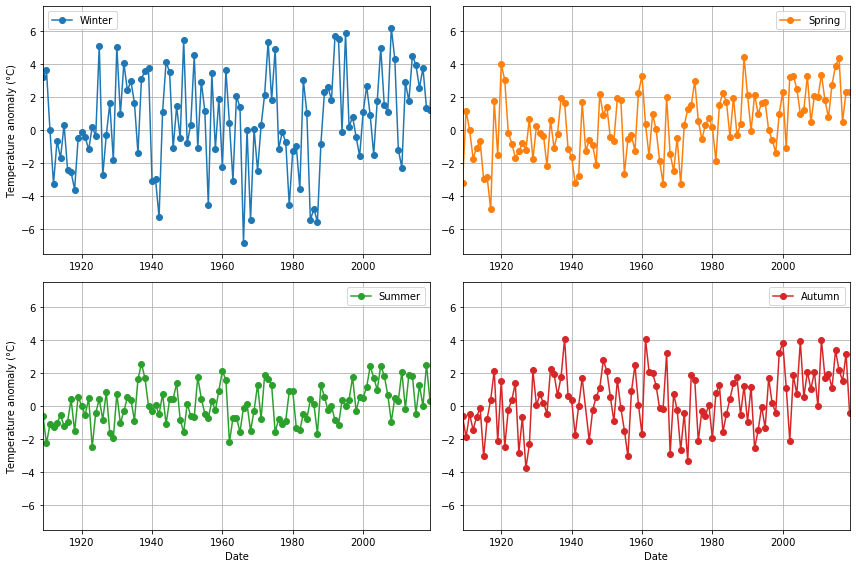

In [24]:
nrows=2
ncols=2

fig, axes = plt.subplots(nrows, ncols, figsize=(12,8))
for i in range(nrows):
    for j in range(ncols):
        if (i==0) and (j==0):
            axes[i,j].plot(winter_temps['YEAR'], winter_temps['DIFF'], marker='o', color='tab:blue', label='Winter')
        if (i==0) and (j==1):
            axes[i,j].plot(spring_temps['YEAR'], spring_temps['DIFF'], marker='o', color='tab:orange', label='Spring')
        if (i==1) and (j==0):
            axes[i,j].plot(summer_temps['YEAR'], summer_temps['DIFF'], marker='o', color='tab:green', label='Summer')
        if (i==1) and (j==1):
            axes[i,j].plot(autumn_temps['YEAR'], autumn_temps['DIFF'], marker='o', color='tab:red', label='Autumn')
        axes[i,j].set_xlim([1909, 2019])
        axes[i,j].set_ylim([-7.5, 7.5])
        if i == 1:
            axes[i,j].set_xlabel('Date')
        if j == 0:
            axes[i,j].set_ylabel('Temperature anomaly (°C)')
        axes[i,j].grid()
        axes[i,j].legend()

plt.tight_layout()
plt.savefig('seasonal-averages.png', dpi=300)